https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/generative_adversarial_network/main.py

참조

In [8]:
import os
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
from torchvision.utils import save_image
from matplotlib import pyplot as plt

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper-parameters
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100
root_dir = '/content/drive/MyDrive/MLDL/DCGAN'
sample_dir = root_dir + '/samples_vanilla'

# Create a directory if not exists
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [3]:
# Change current path
os.chdir(root_dir)
print(os.getcwd())

/content/drive/MyDrive/MLDL/DCGAN


In [4]:
# Image processing
# transform = transforms.Compose([
#                 transforms.ToTensor(),
#                 transforms.Normalize(mean=(0.5, 0.5, 0.5),   # 3 for RGB channels
#                                      std=(0.5, 0.5, 0.5))])
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5],   # 1 for greyscale channels
                                     std=[0.5])])


In [6]:
# MNIST dataset
mnist = torchvision.datasets.MNIST(root='../data/',
                                   train=True,
                                   transform=transform,
                                   download=False)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=mnist,
                                          batch_size=batch_size, 
                                          shuffle=True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


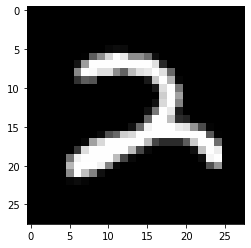

In [9]:
# Check Dataset
for i in data_loader:
  plt.imshow(i[0][0][0,:,:],cmap='gray')
  break

In [10]:
# Discriminator
D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [11]:
# Generator 
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

In [12]:
# Device setting
D = D.to(device)
G = G.to(device)

In [13]:
# Binary cross entropy loss and optimizer
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [14]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

In [15]:
# Start training
total_step = len(data_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        images = images.reshape(batch_size, -1).to(device)
        
        # Create the labels which are later used as input for the BCE loss
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # ================================================================== #
        #                      Train the discriminator                       #
        # ================================================================== #

        # Compute BCE_Loss using real images where BCE_Loss(x, y): - y * log(D(x)) - (1-y) * log(1 - D(x))
        # Second term of the loss is always zero since real_labels == 1
        outputs = D(images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        '''
         D에 real image를 넣어 output으로 뽑아낸다.
         이렇게 뽑아낸 output에는 batch_size 만큼의 D가 입력 이미지를 판별한 결과가 들어갈것이다.
          (예를들어 batch_size = 5 라면 [ 1 1 0 1 0 ] 이런식으로 output에 결과값이 들어갈것이다.)
         그런데 실제로 들어간 이미지는 모두 real image이므로 결과값은 [ 1 1 1 1 1 ] 이 나와야한다.
         그래서 우리가 미리 torch.ones(batch_size, 1)로 만들어둔 real_labels를 이용해 이와 BCE를 계산하여 Loss를 나타낸다.
        '''
        
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        '''
         위와 마찬가지인데 반대인 경우이다.
         이번에 넣어준 이미지는 Generator에서 만든 가짜 이미지이다.
         그렇다면 Discriminator는 이 이미지들을 모두 가짜(0) 라고 판단해야 가장 좋은 경우이다.
         그렇기 때문에 D에서 나온 output을 우리가 미리 만들어둔 0으로 가득 차있는 fake_labels와 비교하여 BCE를 계산한다. 
        '''
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        reset_grad()
        d_loss.backward()
        d_optimizer.step()
        '''
         실제 loss 계산은 위 두 loss를 합하여 계산한다.
         여러개의 loss가 있는 경우에는 대부분 저렇게 단순 합을 하여 loss를 계산한다.
         합으로 하는 이유는 backprob 과정에서 + 연산일시 나에게 필요한 loss는 미분돼어 흘러오지만 필요없는 loss는
         상수처리 돼어 미분시 0이 되기 때문에 그런듯함.
         근데 reset_grad()는 왜 해주는것인지 잘 모르겠다. 처음에 하는것이면 gradient를 초기화한 후에 학습을 진행하는것이니 알겠는데
         왜 for문 안쪽에 이게 들어있는것이지? 이러면 계속 gradient가 초기화되는것 아닌가.
          => 이전의 gradient는 없애고 이번 구역에서의 gradient를 계산하기 위함인듯함
        '''
        
        # ================================================================== #
        #                        Train the generator                         #
        # ================================================================== #

        # Compute loss with fake images
        z = torch.randn(batch_size, latent_size).to(device)
        fake_images = G(z)
        outputs = D(fake_images)
        '''
         G의 경우 latent variable z에서 이미지를 생성한다.
         z는 랜덤한 노이즈로 이루어진 값이다.
         G를 학습할때는 생성한 이미지가 D를 통해 감별돼었을 때 모두 real image로 나오게 하면 된다.
         따라서 D(fake_images)가 모두 [ 1 1 1 1 1 ]이 나오게 하면 된다.
        '''
        # We train G to maximize log(D(G(z)) instead of minimizing log(1-D(G(z)))
        # For the reason, see the last paragraph of section 3. https://arxiv.org/pdf/1406.2661.pdf
        g_loss = criterion(outputs, real_labels)
        '''
         위에 말한것처럼 학습을 할 때 ouptuts과 real_labels를 비교하여 BCE를 구한다.
         원래 논문에서나 수식적으로는 log(1-D(G(z)))를 minimize하도록 학습하는것이 옳다.
          (학습이 잘 된다면 D(G(z))는 1에 가까워질것이고 위 수식은 log 0 에 가까워진다. log 0은 -inf 이므로 minimize 하는것)
         그러나 log x 그래프가 log 1 부근에서 상대적으로 기울기가 굉장히 완만하고, log 0 부근에서는 기울기가 가파른것을 이용해 학습을 빠르게 하기 위한 기법이다.
         log(1-D(G(z)))를 minimize하는 대신 log(D(G(z)))를 maximize한다면 최초 학습 구간인 log 0 부근에서 빠르게 학습을 진행할 수 있다.
        '''

        # Backprop and optimize
        reset_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (i+1) % 200 == 0 :
          print(outputs[30:40])
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
    
    # Save real images
    if (epoch+1) == 1:
        images = images.reshape(images.size(0), 1, 28, 28)
        save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'))
    
    # Save sampled images
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    print(fake_images.size())
    save_image(denorm(fake_images), os.path.join(sample_dir, 'fake_images-{}.png'.format(epoch+1)))

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
Epoch [52/200], Step [600/600], d_loss: 0.5321, g_loss: 1.9985, D(x): 0.85, D(G(z)): 0.21
torch.Size([100, 1, 28, 28])
tensor([[0.0465],
        [0.1202],
        [0.1147],
        [0.0802],
        [0.1717],
        [0.0961],
        [0.0210],
        [0.1831],
        [0.5407],
        [0.0928]], device='cuda:0', grad_fn=<SliceBackward>)
Epoch [53/200], Step [200/600], d_loss: 0.7522, g_loss: 2.2530, D(x): 0.74, D(G(z)): 0.19
tensor([[0.0202],
        [0.0754],
        [0.0194],
        [0.1517],
        [0.0479],
        [0.0490],
        [0.0515],
        [0.0454],
        [0.0642],
        [0.0421]], device='cuda:0', grad_fn=<SliceBackward>)
Epoch [53/200], Step [400/600], d_loss: 0.4966, g_loss: 2.5721, D(x): 0.82, D(G(z)): 0.14
tensor([[0.0248],
        [0.0079],
        [0.1668],
        [0.0948],
        [0.0141],
        [0.7069],
        [0.0227],
        [0.6499],
        [0.0258],
        [0.2276]], device='cuda:0', grad_fn=<SliceBackwar